# Stochastic modelling of COVID19 dataset
## Initial setup

In [5]:
library(plyr)
library(tidyr)
library(tidyverse)
library(deSolve)
library(bbmle)
options(repr.plot.width = 8, repr.plot.height =4.5)
dev.new(width=8, height=2.5)
set.seed(1234)

## Base Model: SIR
Now to warm up, we want to use the standard SIR model with no population dynamics:

$\frac{dS}{dt} = -\beta{S}{I}$

$\frac{dI}{dt} = \beta{S}{I} - \gamma{I}$

$\frac{dR}{dt} = \gamma{I}$

Creating this model in R:

In [184]:
SIR <- function(time, variables, parameters) {
  with(as.list(c(variables, parameters)), {
    dS <- -beta * S * I
    dI <- beta * S * I - gamma * I
    dR <-  gamma * I
    return(list(c(dS, dI, dR)))
  })
}

We then create a function to return an approximate value for our model given all parameters. We can make this return our infectious curve without the first point for fitting, and then the full model for displaying a fit that we like.

In [1]:
model <- function (gamma, beta, times, initial_data, fullData=FALSE) {
    out <- ode(func=SIR, y=initial_data,
               times=times,parms=c(gamma=gamma,beta=beta))
    if(fullData){
        return(out)
    }
    return(out[-1,3])
}

## Dataset: Flu in Boarding School
We have the classic dataset from a flu outbreak in a boarding school. Obtained from https://rdrr.io/cran/outbreaks/man/influenza_england_1978_school.html

In [228]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv', header=TRUE))
N = 763
I0 = df$cases[1]
end_time <- tail(df, n=1)$days
initial_conditions <- c(S=(N-I0), I=I0, R=0)
initial_conditions

S   I   R 
760   3   0

And the graphing our cases over time:

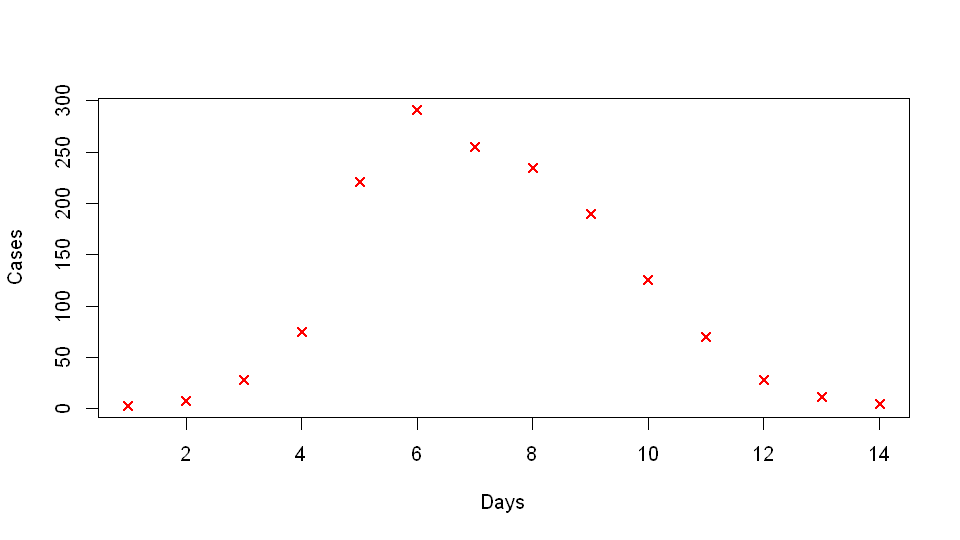

In [195]:
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='red', pch=4, lwd=1.6)

Some code to make graphing a bit quicker:

In [205]:
compare_model <- function(model, title){
    plot(df$days, df$cases, xlab='Days', ylab='Cases', col='red', lwd=1.6, pch=4)
    legend(1, 250, legend=c("Predicted", "Actual"),
           col=c("red", "grey"), lty=1:5, y.intersp=2)
    
    lines(loess(model$I~model$time), col='black', lty=5)
    title(title)
}

## Initial Parameters
It is helpful in the following estimations to give our optimiser initial values of our parameters. These help our optimiser to determine the magnitude of our parameters. Our initial parameter choice is important as our optimiser could prematurely stop before reaching a useful result if we provide bad initial parameters.

## Parameter Estimation: MLE's using Normal Distribution 
We now want to create a maximum likelihood estimator of our model, with the aim of numerically maximising this to find estimates for our model's parameters.
We first assume each observation is normally distributed, with constant variance $\sigma^2$:

$Y_t \sim N(I_t, \sigma^2)$.
We want a function that will give a log likelihood of our dataset. To do this generally, assume that each datapoint has the same distribution with parameters $\underline{\theta}$, so each datapoint has the PDF: $f(y |  \underline{\theta})$.
Then our likelihood function is: 
$L =\displaystyle \prod_{t=0}^{n-1}f(Y_t | \underline{\theta}_t)$,
and our log likelihood function is:
$L =\displaystyle \sum_{t=0}^{n-1}\log{(f(Y_t | \underline{\theta}_t))}$ 

At first this is a normal distribution so the likelihood function can be implemented. We return the minus log likelihood as this is what our package uses to estimate parameters.




In [2]:
likelihood <- function(gamma, beta,sigma){
    gamma <- exp(gamma)
    beta <- exp(beta)
    sigma <- exp(sigma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial_conditions)
    print(model_data)
    -sum(dnorm(x=df$cases[-1],mean=model_data[-1], sd=sigma, log=TRUE))
}

Our aim is then to maximimise our log-likelihood function, which we can do using the `bblme` package.

In [6]:
initial_params <- list(beta = 0.5, gamma = 0.05, sigma = 1)
results <- mle2(minuslogl = likelihood, start = lapply(initial_params, log),method = "Nelder-Mead",)
parameters <- exp(coef(results))
parameters

ERROR: Error in ode(func = SIR, y = initial_data, times = times, parms = c(gamma = gamma, : object 'initial_conditions' not found


Now we can compare our estimate against our data

time,S,I,R
1,760.0000,3.0000000,0.0000000
2,759.9847,2.6252038,0.3900494
3,759.9714,2.2972304,0.7313702
4,759.9597,2.0102309,1.0300493
5,759.9495,1.7590871,1.2914135
6,759.9406,1.5393188,1.5201251
7,759.9327,1.3470083,1.7202615
8,759.9259,1.1787228,1.8953952
9,759.9199,1.0314615,2.0486490
10,759.9146,0.9025981,2.1827563


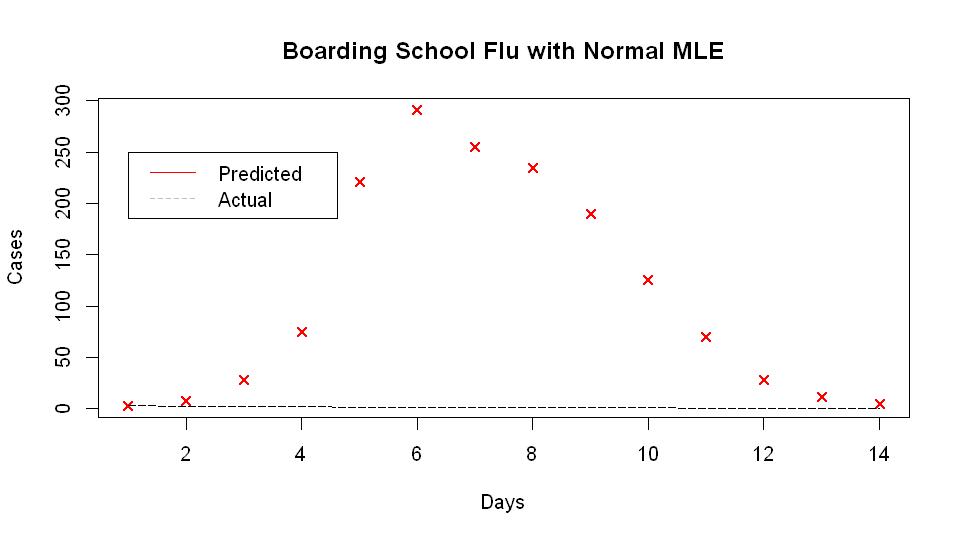

In [250]:
normal_model <- data.frame(model(gamma=as.double(parameters['gamma']), beta=as.double(parameters['beta']), times=df$days, initial_data=initial_conditions, fullData=TRUE))
normal_model
compare_model(normal_model,'Boarding School Flu with Normal MLE' )

## Parameter Estimation: MLE's using Poisson Distribution
We can try a Poisson distribution instead: $Y_t \sim Po(I_t)$. Our log-likelihood function is then:

In [175]:
likelihood_po <- function(gamma, beta){
    beta <- exp(beta)
    gamma <- exp(gamma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial_conditions)
    -sum(dpois(x = df$cases[-1], lambda = model_data[-1], log = TRUE))
}

We can then repeat our estimation:

In [180]:
po_initial_params <- c(gamma=0.5, beta=0.005)
po_results <- mle2(minuslogl = likelihood_po, start = lapply(po_initial_params, log),method = "Nelder-Mead")
po_parameters <- exp(coef(po_results))
po_parameters

gamma        beta 
0.454269982 0.001893685

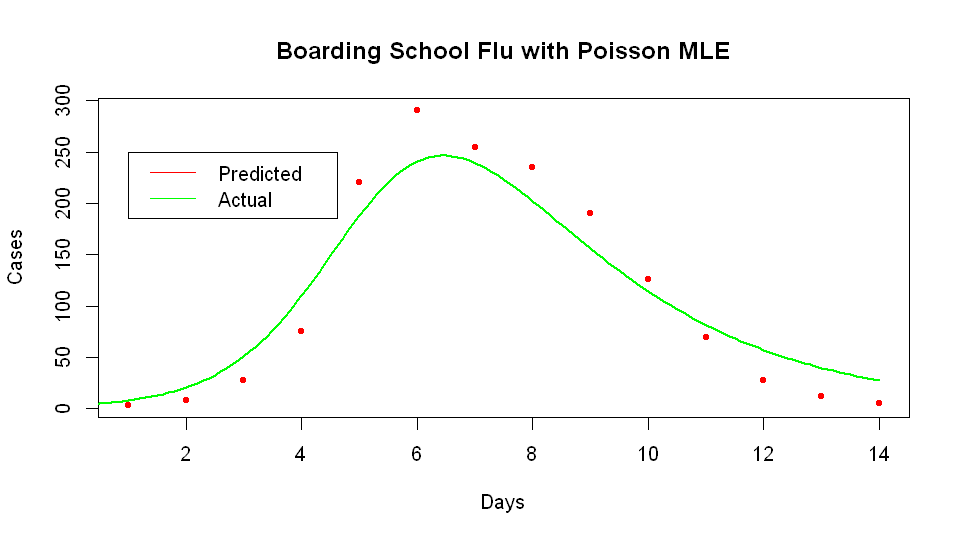

In [181]:
po_model <- data.frame(model(gamma=as.double(po_parameters['gamma']), beta=as.double(po_parameters['beta']),
                  times=seq(0,end_time, 0.1), initial_data=initial_conditions, fullData=TRUE))

compare_model(po_model, 'Boarding School Flu with Poisson MLE')


## Parameter Estimation: MLE's using Negative Binomial Distribution


## Model Comparison
Now we seek to compare the two variations of our model. Both models work by seeking to maximise the log-likelihood given that our data has a certain distribution. Hence from this perspective, the more "better" model would be the one with a larger log-likelihood.

Our Normal log-likelihood value:

In [15]:
-logLik(results)

'log Lik.' 60.15289 (df=3)

Our Poisson log-likelihood value:

In [16]:
-logLik(po_results)

'log Lik.' 103.0863 (df=2)

So from this perspective the Poisson model is an improvement of the Normal model. 
## Fitting $I_0$
We could also try and fit $I_0$, by first applying the bound $1 \leq I_0 \leq I(0)$. Then we can remove it from our data fields and add it to our parameters to be fitted instead. Using our Normal likelihood:

In [17]:
likelihood_i <- function(gamma, beta, I, sigma){
    beta <- exp(beta)
    gamma <- exp(gamma)
    I <- exp(I)
    sigma<-exp(sigma)
    initial <- c(S=as.double(initial_conditions['S']), I=I, R=as.double(initial_conditions['R']))
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial)
    -sum(dnorm(x=df$cases[-1],mean=model_data[-1], sd=sigma, log=TRUE))
}

gamma         beta            I        sigma 
 0.453569244  0.002303697  0.636126270 16.302976741

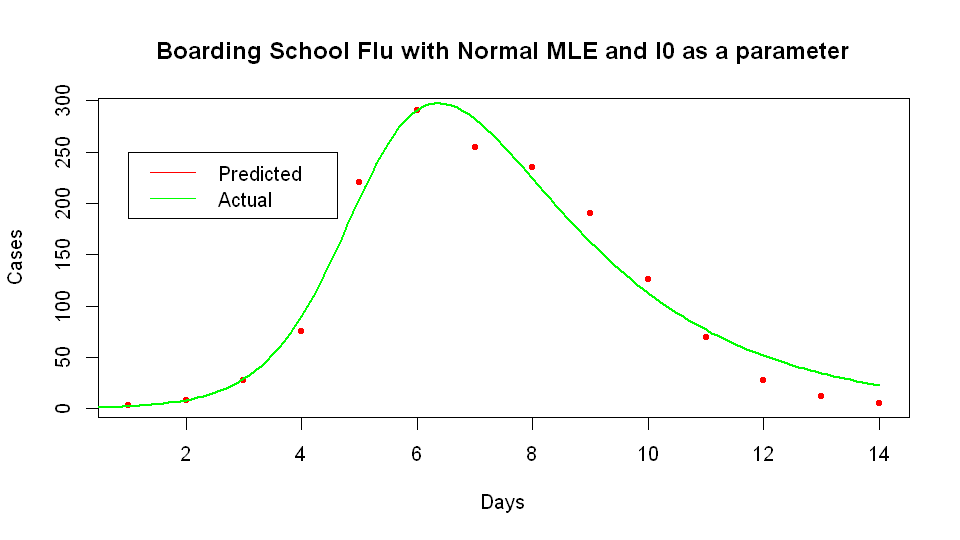

In [49]:
i_initial_params <- c(gamma=0.5, beta=0.005, I=3, sigma=10)
i_results <- mle2(minuslogl = likelihood_i, start = lapply(i_initial_params, log), method = "Nelder-Mead")
i_parameters <- exp(coef(i_results))
i_parameters
i_model <- data.frame(model(gamma=as.double(i_parameters['gamma']), beta=as.double(i_parameters['beta']),
                  times=seq(0,end_time, 0.1), initial_data=c(S=as.double(initial_conditions['S']), I=as.double(i_parameters['I']), R=as.double(initial_conditions['R'])), fullData=TRUE))

compare_model(i_model, 'Boarding School Flu with Normal MLE and I0 as a parameter')

## Deterministic Analysis
We now seek to compare these models. We can do this in several ways: 
1. Find the lowest AIC score. 
2. Compare parameter uncertainties (in some way).
3. Find the lowest sum of square errors.
### AIC Scores
Using the formula for AIC scores: 
$\text{AIC} = 2K - 2\log{L(\hat{\theta}, y)}$. 
Since our models are done by maximimising our log-likelihood, we can compute these scores directly from our previous calculations: 

In [50]:
aic_scores <- c(Normal=6 - logLik(results), Poisson=4 - logLik(po_results), Normal_I0=8 - logLik(i_results) )
sort(aic_scores)

Normal_I0    Normal   Poisson 
 62.71495  66.15289 107.08632

So the best model is our Normal MLE model with $I_0$ fitted.

### Residual Sum of Squares
We look to calculate the residual sum of squares. 

In [94]:
rss <- function(model, incidence){
    data <- filter(model, time%%1==0)
    sum((data$I[-1] - incidence$cases)^2)
}

In [95]:
rss_scores <- c(Normal=rss(normal_model, df), Normal_I0=rss(i_model, df), Poissson=rss(po_model, df))
sort(rss_scores)

Normal_I0    Normal  Poissson 
 3759.476  8441.406 10380.792

So the best model is our Normal MLE model with $I_0$ fitted in regards to RSS as well.

## Event Driven Models
We now use the parameters that we have determined from our deterministic model to simulate a stochastic model. First we do the Gillespie Direct Algorithm. Our step function will take a single step given parameters `x=(time, X,Y,Z), params=(beta=beta, gamma=gamma)`.

In [22]:
step <- function(x, params){
  S <- x[2]
  I <- x[3]
  R <- x[4]
  N <- S+I+R
  beta <- params['beta']
  gamma <- params['gamma']
    
  rates <- c(transmission=beta*S*I,
             recovery=gamma*I)
  
  transitions <- list(
    transmission=c(-1,1,0),
    recovery=c(0,-1,1)
  )
  
  rate_total <- sum(rates)
  tau <- rexp(n=1,rate=rate_total)

    
  event <- sample.int(n=2,size=1,prob=rates/rate_total)
  x+c(tau,transitions[[event]])
}

This will of course handle time as well, we just have to run our step as many times as necessary to get to a certain time index.

In [23]:
simulate <- function(x, params, maximum_step=10000){
    output <- array(dim=c(maximum_step+1,4))
    colnames(output) <- names(x)
    output[1,] <- x
    i <- 1
    while(i<=maximum_step&&x["I"]>0){
        i <- i+1
        output[i,] <- x <- step(x,params)
    }
    as.data.frame(output[1:i,])
}

Then we can run some simulations, we use the parameters from our Normal with $I_0$ fit.

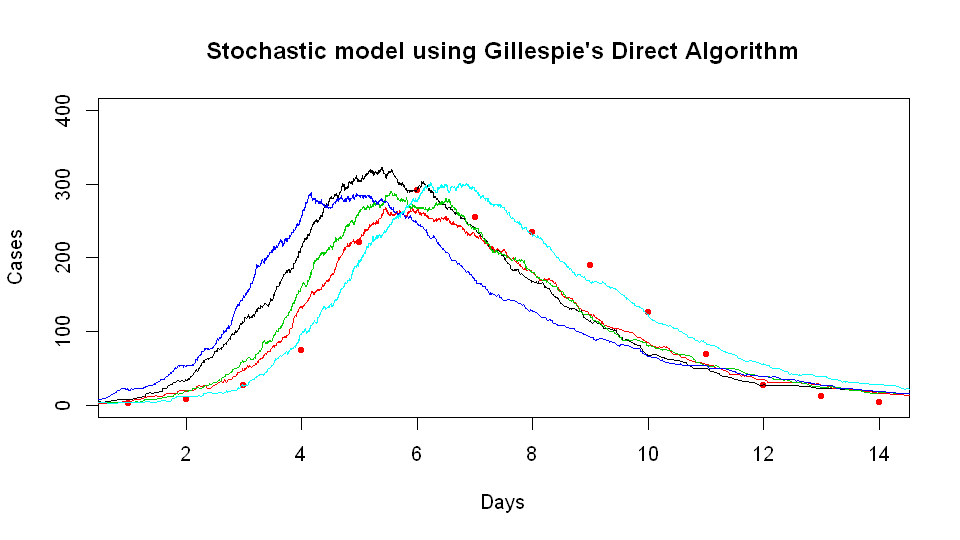

In [24]:
stochastic_initial <- c(time=0, initial_conditions)
simulation_data<- rdply(
  5,
  simulate(stochastic_initial,i_parameters)
)
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='red', lwd=2, pch=20, ylim=c(0,400))
d_ply(simulation_data,".n",function(x)lines(I~time,data=x, col=.n))
title("Stochastic model using Gillespie\'s Direct Algorithm")